# Linear regression vs Polynomial regression vs SVM

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import kagglehub
from kagglehub import KaggleDatasetAdapter
import time
import joblib
import os


## Import dataset

In [12]:
# Load dataset from online source (kaggle). Source: https://www.kaggle.com/datasets/mirichoi0218/insurance
file_path = "insurance.csv"
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,
  "mirichoi0218/insurance",
  file_path,)
df.info()

/var/folders/s5/8l7hsvns557325k6kcpgrp1h0000gn/T/ipykernel_46360/3317906159.py:3: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


If you don't want to load it from online, you can download the dataset from above source or from this repository, but if you would like to share it, please acknowledge the online source (kaggle)

In [13]:
# Load dataset offline
# df = pd.read_csv("filepath")
# df.info()

In [14]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [15]:
# Convert sex and smoker features to numerical values
df['sex'] = df['sex'].map({'female': 0, 'male': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

In [16]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


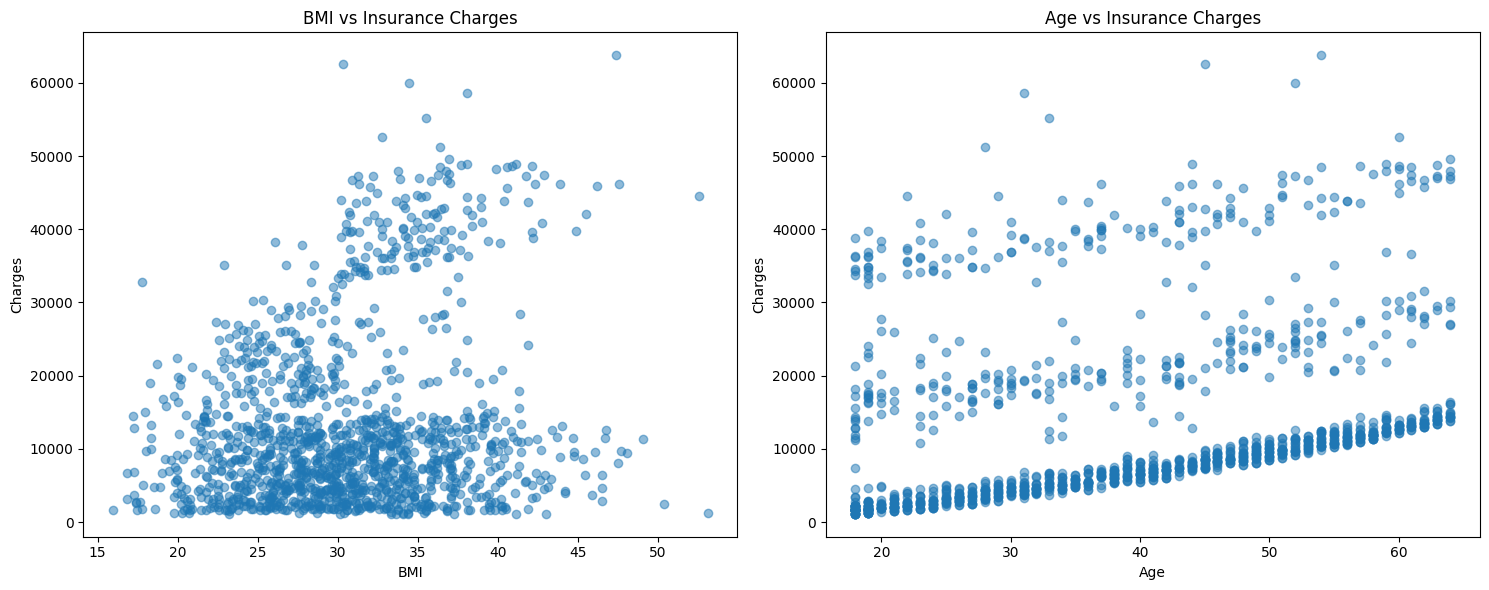

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# BMI vs Charges
ax1.scatter(df['bmi'], df['charges'], alpha=0.5)
ax1.set_xlabel('BMI')
ax1.set_ylabel('Charges')
ax1.set_title('BMI vs Insurance Charges')

# Age vs Charges
ax2.scatter(df['age'], df['charges'], alpha=0.5)
ax2.set_xlabel('Age')
ax2.set_ylabel('Charges')
ax2.set_title('Age vs Insurance Charges')

plt.tight_layout()
# plt.savefig('scatter_plots.png')

Feature comparison does not exhibit any clear or known pattern

In [18]:
X = df[["age", "sex", "bmi", "children", "smoker"]]
y = df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

## Training and Inference

In [19]:
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

In [20]:
# Define models
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Bagging Tree': BaggingRegressor(n_estimators=100, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}


results = []
dataset_prefix = 'insurance'
# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        'Model': name,
        'Train R²': r2_score(y_train, y_train_pred),
        'Test R²': r2_score(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Training Time': training_time
    }
    results.append(metrics)
    # Save the models
    model_filename = os.path.join(models_dir, f"{dataset_prefix}_{name.lower().replace(' ', '_')}.pkl")
    joblib.dump(model, model_filename)

# Display results
results_df = pd.DataFrame(results)
print(results_df.round(3))


               Model  Train R²  Test R²  Train RMSE  Test RMSE  Train MAE  \
0      Decision Tree     0.998    0.719     494.206   6601.467     29.573   
1       Bagging Tree     0.973    0.858    1978.266   4699.780   1075.603   
2      Random Forest     0.973    0.858    1990.989   4695.510   1087.373   
3  Gradient Boosting     0.896    0.879    3874.546   4342.914   2117.445   

   Test MAE  Training Time  
0  3159.722          0.003  
1  2547.435          0.134  
2  2550.748          0.109  
3  2424.532          0.043  


In [22]:
os.makedirs('output', exist_ok=True)
# Save the results to a CSV file
results_df.to_csv(os.path.join('output', f"{dataset_prefix}_trees_results.csv"), index=False)